# Demo Iterative fitting process

RIFT's essence is iterative fitting :  active learning of a gaussian process approximation to a (log) likelihood, to compute a posterior distribution.

In this demo, we illustrate the key elements of RIFT with a low-dimensional toy model

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C
import scipy

# If RIFT is not installed, uncomment out the next lines
#!pip install --user RIFT==0.0.15.4rc5 # if not installed
#import sys
#for name in sys.path:
#    print(name)
#sys.path.append('/Users/rossma/.local/lib/python3.8/site-packages')
#sys.path.append('//Library/Python/3.7/site-packages')
import RIFT.mcsampler as mcsampler


ModuleNotFoundError: No module named 'glue'

In [44]:
def lnL_true(x,sigma=1.):
    return 45-np.diagonal(np.dot(x,x.T))/2*sigma**2
    
# Make our life easier: hypercube domain
x_prior_max = 10
x_prior_min=-10
def CIP(x_in, y_in,y_err=None,npts_out=10,use_mcsampler=False):
    n_params = len(x_in[0])
    # Estimate some characteristic sizes from the data
    length_scale_est=[]
    length_scale_bounds_est=[]
    for indx in np.arange(len(x_in[0])):
        length_scale_est.append( 2*np.std(x_in[:,indx])  )  # auto-select range based on sampling retained
        length_scale_min_here= np.max([1e-3,0.2*np.std(x_in[:,indx]/np.sqrt(len(x_in)))])
        length_scale_bounds_est.append( (length_scale_min_here , 5*np.std(x_in[:,indx])   ) )  # 
    # Make a GP approximation to y(x) = lnL(x)
    kernel = WhiteKernel(noise_level=0.1,noise_level_bounds=(1e-2,1))+C(0.5, (1e-3,1e1))*RBF(length_scale=length_scale_est, length_scale_bounds=length_scale_bounds_est)
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=8)
    gp.fit(x_in,y_in)
    def likelihood_function(x):
        return np.exp(gp.predict(x))
    
    if not use_mcsampler:
        # Perform MC integral with uniform sampling and a uniform prior
        x_trial = np.random.uniform(x_prior_min,x_prior_max,size=(300*npts_out,n_params))
        L_trial = likelihood_function(x_trial)
        indx_out = np.random.choice(len(x_trial),size=npts_out,p=L_trial/np.sum(L_trial))
        return x_trial[indx_out,:]
    
    # Perform MC integral with mcsampler
    sampler = mcsampler.MCSampler()
    coord_names =[]
    for name in np.arange(len(x_in[0])):
        name_str = "x_"+str(name)
        coord_names.append(name_str)
        sampler.add_parameter(name_str,pdf = np.vectorize(lambda x:1./(x_prior_max - x_prior_min)), left_limit=x_prior_min,right_limit=x_prior_max, adaptive_sampling=True)

    res, var, neff, dict_return = sampler.integrate(likelihood_function,*coord_names, nmax=1e5, n_eff=1000,save_integ=True,tempering_adapt=True,adapt_weight_exponent=0.1,floor_level=1e-3)
    samples = sampler._rvs # pull out samples
    
    # reformat data 
    x_out = np.zeros((npts_out,n_params))
    for indx in np.arange(n_params):
        x_out[:,indx] = samples[coord_names[indx]]
    return x_out

def puffball(x_in, puff_factor=3):
    # adds random errors to all coordinates
    x_out = np.zeros(x_in.shape)
    n_params = len(x_out[0])
    cov = np.cov(x_in.T)
    cov = cov*puff_factor*puff_factor
    # Normally we would check for singularities and regularize here...
    # Draw offsets
    rv = scipy.stats.multivariate_normal(mean=np.zeros(n_params), cov=cov,allow_singular=True)  # they are just complaining about dynamic range of parameters, usually
    delta_X = rv.rvs(size=len(x_in))
    x_out = x_in+delta_X
    return x_out

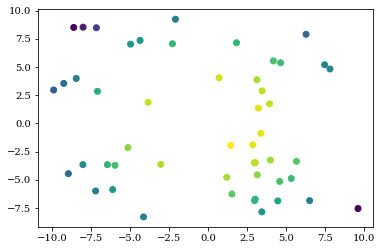

In [4]:
# Initial data
x_in_init = np.random.uniform(x_prior_min,x_prior_max,size=(50,2))
y_in_init = lnL_true(x_in_init)
plt.scatter(x_in_init[:,0],x_in_init[:,1], c=y_in_init)

[  42 4942 9924 8506 4056  584 8084   35  362 7848]


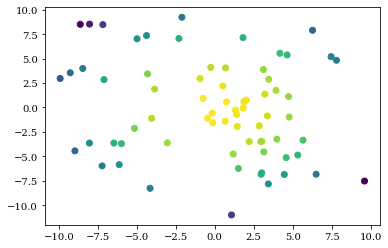

In [38]:
# Step 1
#   - CIP generates test points based on the likelihood fit
x_1=CIP(x_in_init,y_in_init)
#   - puffball adds random errors
x_1_puff = puffball(x_1)
#   - we evaluate the likelihood on those points
x_1_net = np.concatenate((x_in_init,x_1,x_1_puff))
y_1_net = np.concatenate((y_in_init,lnL_true(x_1), lnL_true(x_1_puff)))
plt.scatter(x_1_net[:,0],x_1_net[:,1], c=y_1_net)

[8370  528 1289 9863 2915  954 3966 4697 4153 6381]


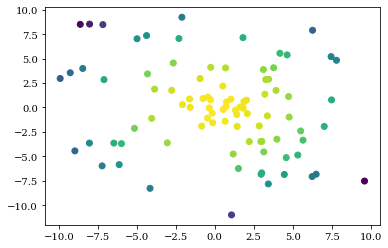

In [40]:
# Step 2
#   - CIP generates test points based on the likelihood fit
x_now = x_1_net; y_now = y_1_net;
x_next=CIP(x_now,y_now)
#   - puffball adds random errors
x_next_puff = puffball(x_next)
#   - we evaluate the likelihood on those points
x_next_net = np.concatenate((x_now,x_next,x_next_puff))
y_next_net = np.concatenate((y_now,lnL_true(x_next), lnL_true(x_next_puff)))
plt.scatter(x_next_net[:,0],x_next_net[:,1], c=y_next_net)

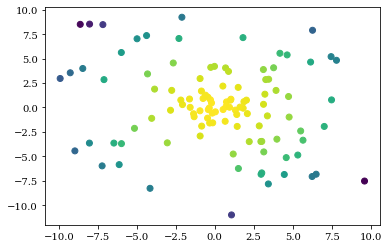

In [42]:
# Step 3
#   - CIP generates test points based on the likelihood fit
x_now = x_next_net; y_now = y_next_net;
x_next=CIP(x_now,y_now)
#   - puffball adds random errors
x_next_puff = puffball(x_next)
#   - we evaluate the likelihood on those points
x_next_net = np.concatenate((x_now,x_next,x_next_puff))
y_next_net = np.concatenate((y_now,lnL_true(x_next), lnL_true(x_next_puff)))
plt.scatter(x_next_net[:,0],x_next_net[:,1], c=y_next_net)

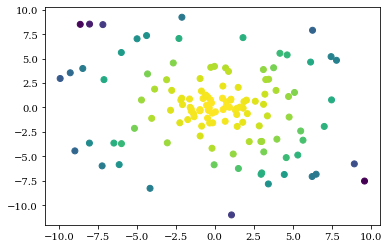

In [43]:
# Step 4
#   - CIP generates test points based on the likelihood fit
x_now = x_next_net; y_now = y_next_net;
x_next=CIP(x_now,y_now)
#   - puffball adds random errors
x_next_puff = puffball(x_next)
#   - we evaluate the likelihood on those points
x_next_net = np.concatenate((x_now,x_next,x_next_puff))
y_next_net = np.concatenate((y_now,lnL_true(x_next), lnL_true(x_next_puff)))
plt.scatter(x_next_net[:,0],x_next_net[:,1], c=y_next_net)

In [46]:
# At some point we decide we are done, 
# and we request a large sample of events from CIP

x_final = CIP(x_next_net,y_next_net,npts_out=10000)

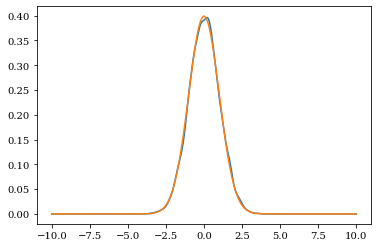

In [79]:
# Now we can make histograms of the result
#   - following scipy kde docs
kernel= scipy.stats.gaussian_kde(x_final[:,0])
xvals = np.linspace(-10,10,300)
yvals=kernel(xvals)
#   - and we compare with the known answer we started with
yvals_true = 1/np.sqrt(2*np.pi) *np.exp(-45+lnL_true(np.array(list([x,0] for x in xvals)))
                   )
plt.plot(xvals,yvals)
plt.plot(xvals,yvals_true)